# The Exploration of Latents with Cutouts

In [103]:
### used to set the interpreter searching path
import sys
target_path = '/home/jovyan/ulmo/'
sys.path.append(target_path)

In [44]:
%matplotlib inline

from importlib import reload
import os
import numpy as np

import pandas

import h5py
import seaborn as sns
import pandas as pd
import umap
from ulmo import io as ulmo_io
from ulmo import plotting

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
from tqdm import trange

### Load the modis data set and latents by SimCLR

In [6]:
### Load modis file from s3
modis_dataset_path = 's3://modis-l2/PreProc/MODIS_2010_95clear_128x128_inpaintT_preproc_0.8valid.h5'
modis_dataset = ulmo_io.load_to_bytes(modis_dataset_path)

In [22]:
with h5py.File(modis_dataset, 'r') as file:
    #print(file.keys())
    modis_train = file['train'][:]

<KeysViewHDF5 ['train', 'train_metadata', 'valid', 'valid_metadata']>


In [235]:
### Load latents from s3
latents_last_file = 's3://modis-l2/modis_latents_simclr/modis_latents_last.h5'
latents_last = ulmo_io.load_to_bytes(latents_last_file)

In [236]:
with h5py.File(latents_last, 'r') as file:
    print(file.keys())
    latents_last = file['modis_latents'][:]

<KeysViewHDF5 ['modis_latents']>


### Latents are 128 dimensional vectors

In [237]:
latents_last.shape

(134162, 128)

## Let's use the PCA to analyse the eigen-values of the latents matrix

## Let's do linear transformation to standarize the latent vector at first.
### For each component, we do $x_{std} = (x - \mu) / \sigma(x)$.

In [238]:
### Initialize the linear transformer at first
scaler = StandardScaler()
### Estimate the parameters
scaler.fit(latents_last)
### Transform the latents
latents_std = scaler.transform(latents_last)

In [239]:
### Let's use PCA at first to estimate the dimension of the main components. But before that, we want to standarize the latent vector
pca = PCA(n_components='mle', random_state=0)
pca.fit(latents_std)
singular_vals = pca.singular_values_

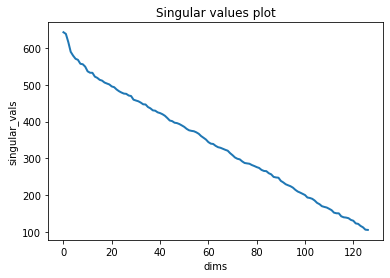

In [7]:
### plot the singular values to estimate the dimensions
plt.figure()
plt.title('Singular values plot')
plt.plot(singular_vals.squeeze(), linewidth=2)
plt.xlabel('dims')
plt.ylabel('singular_vals')
plt.show()

### From above plot, we find that all the components of the latents are essential.
### Here we use $dims = 128$.

latents_embeddingse the UMap to explore the latents. 

### Initialize the umap reducer and fit the umap model

### Create the Scatter Plot of the Reduced Latents Space by UMap

In [240]:
%%time
reducer_umap = umap.UMAP()
latents_embedding = reducer_umap.fit_transform(latents_std)

CPU times: user 14min 5s, sys: 3min 37s, total: 17min 43s
Wall time: 3min 4s


In [241]:
latents_embedding.shape

(134162, 2)

In [244]:
%%time
reducer_umap = umap.UMAP()
latents_mapping = reducer_umap.fit(latents_std)

CPU times: user 13min 50s, sys: 3min 29s, total: 17min 19s
Wall time: 3min


In [39]:
import umap.plot

<AxesSubplot:>

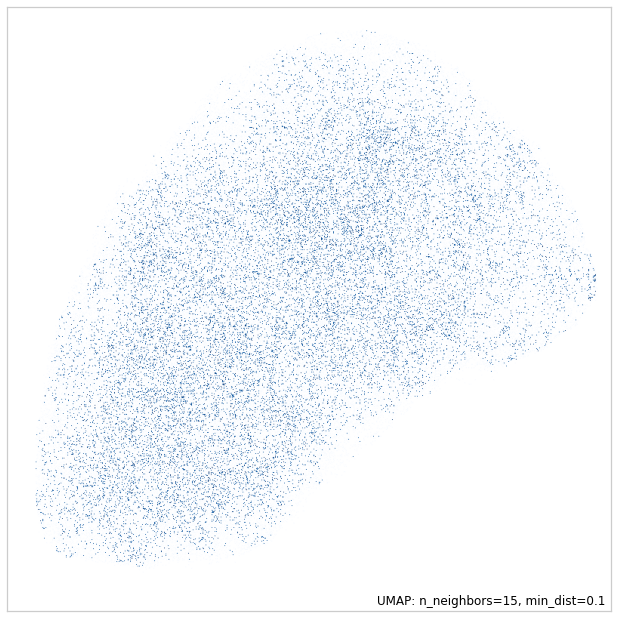

In [245]:
umap.plot.points(latents_mapping)

<AxesSubplot:>

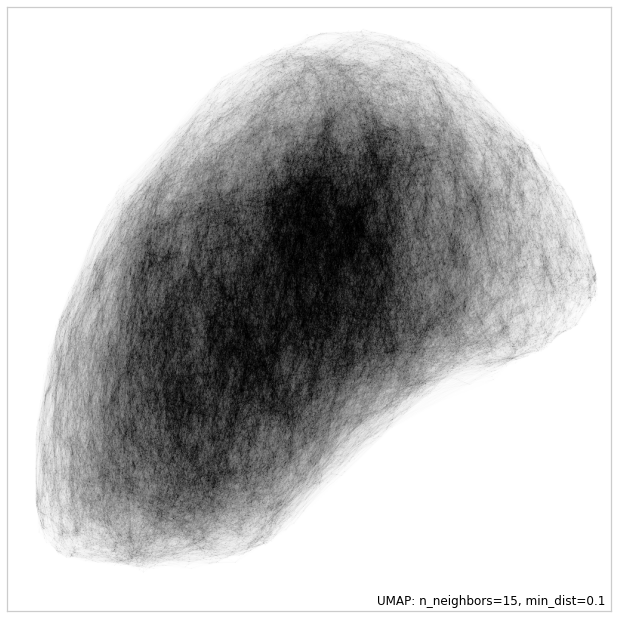

In [246]:
umap.plot.connectivity(latents_mapping, show_points=False)

### show the images

In [42]:
latents_embedding.shape

(134162, 2)

In [45]:
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()

<AxesSubplot:>

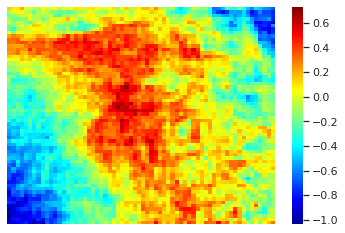

In [48]:
### Show one sample
sns.heatmap(modis_train[0].squeeze(), xticklabels=[], yticklabels=[], cmap=cm, 
             cbar=True)

In [51]:
from sklearn.neighbors import NearestNeighbors

In [67]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(latents_embedding)

In [68]:
distances, indices = nbrs.kneighbors(latents_embedding)

In [74]:
print(f'The shape of distance matrix is: {distances.shape}.')
print(f'The shape of indices matrix is: {indices.shape}.')

The shape of distance matrix is: (134162, 10).
The shape of indices matrix is: (134162, 10).


In [99]:
dist_sets = distances[220]
nearest_imgs = modis_train[indices[220]]

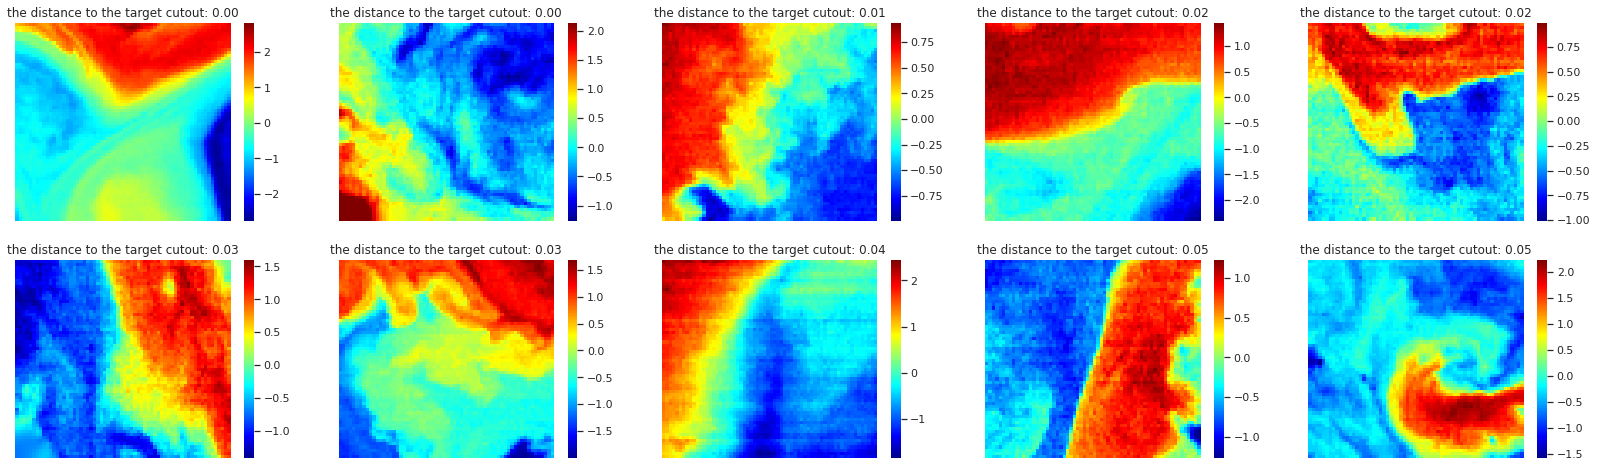

In [100]:
plt.figure(figsize=(28, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.heatmap(nearest_imgs[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_sets[i]:.2f}')

In [104]:
dist_sets = distances[240]
nearest_imgs = modis_train[indices[240]]

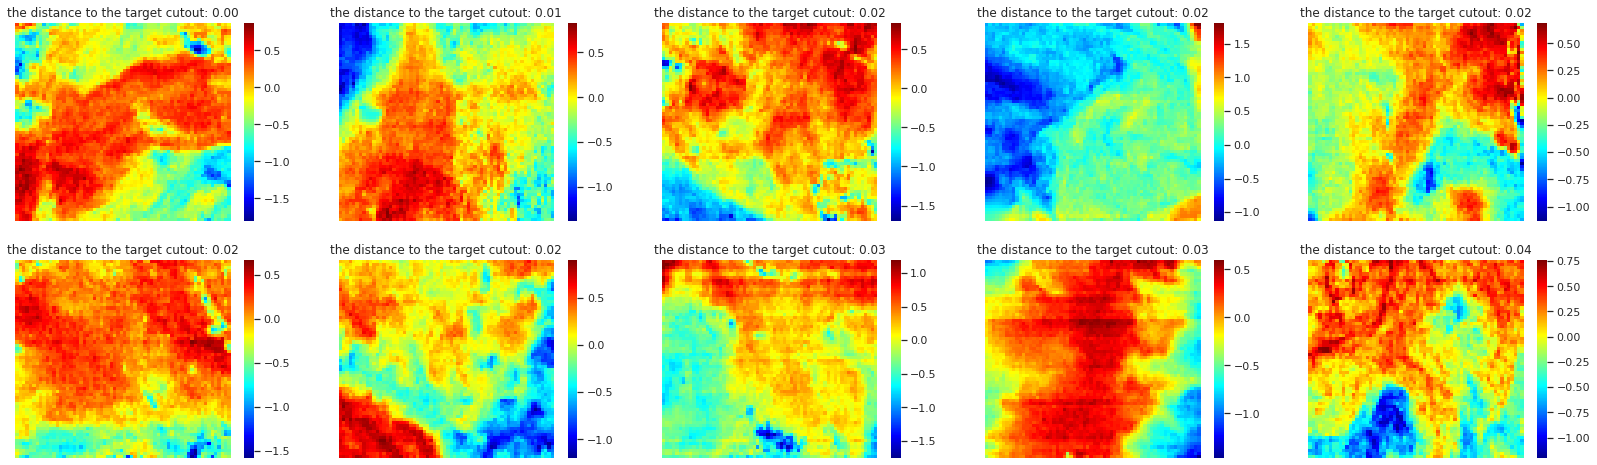

In [105]:
plt.figure(figsize=(28, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.heatmap(nearest_imgs[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_sets[i]:.2f}')

### Sample 5 indices from the nearest neighbor sets

In [132]:
### fix seed
np.random.seed(0)
indice_sampled = np.random.choice(indices.shape[0], 5)
indice_sets = indices[indice_array]
dist_sets = distances[indice_array]

### Show the set 1

In [133]:
imgs_set = modis_train[indice_sets[0]]
dist_set = dist_sets[0]

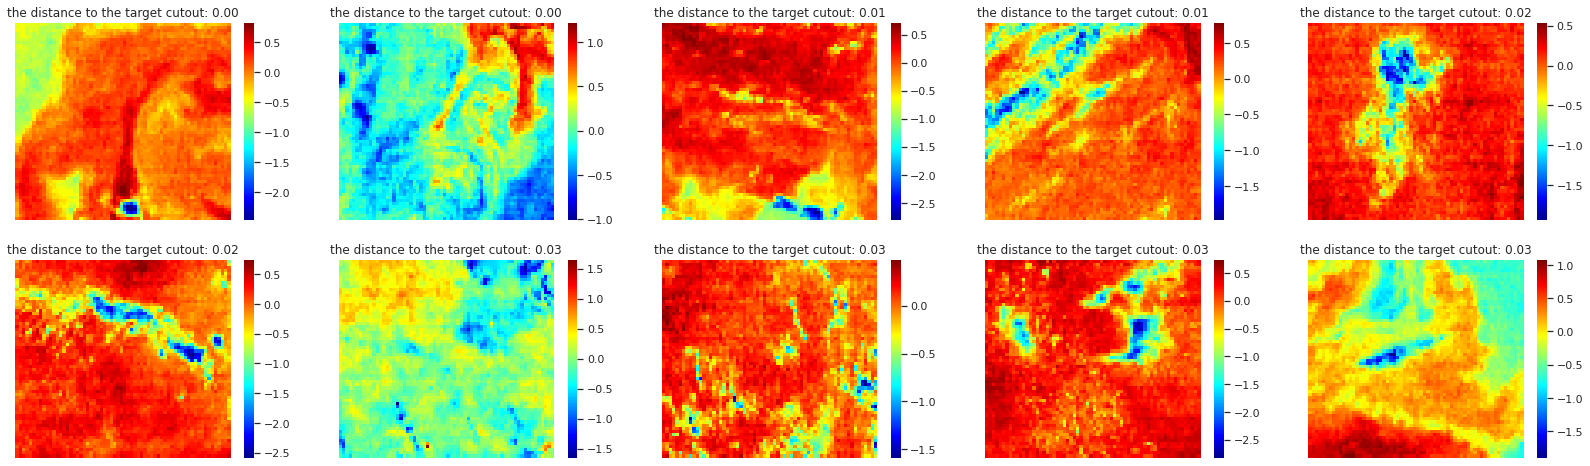

In [134]:
plt.figure(figsize=(28, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

### Show the set 2

In [135]:
imgs_set = modis_train[indice_sets[1]]
dist_set = dist_sets[1]

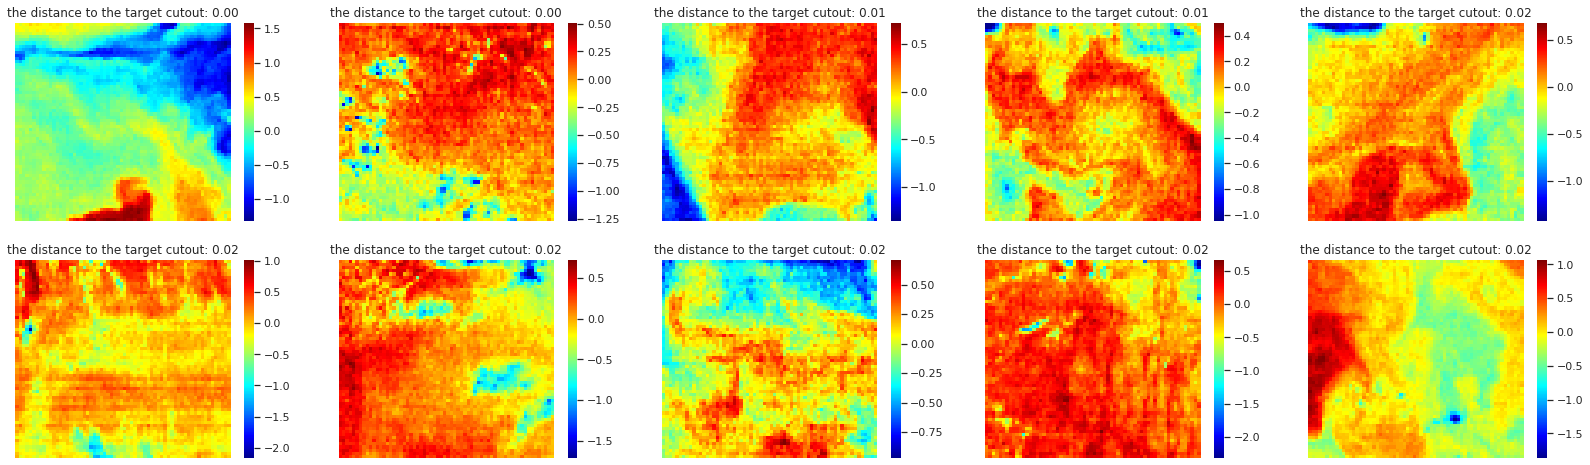

In [136]:
plt.figure(figsize=(28, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

### Show the set 3

In [137]:
imgs_set = modis_train[indice_sets[2]]
dist_set = dist_sets[2]

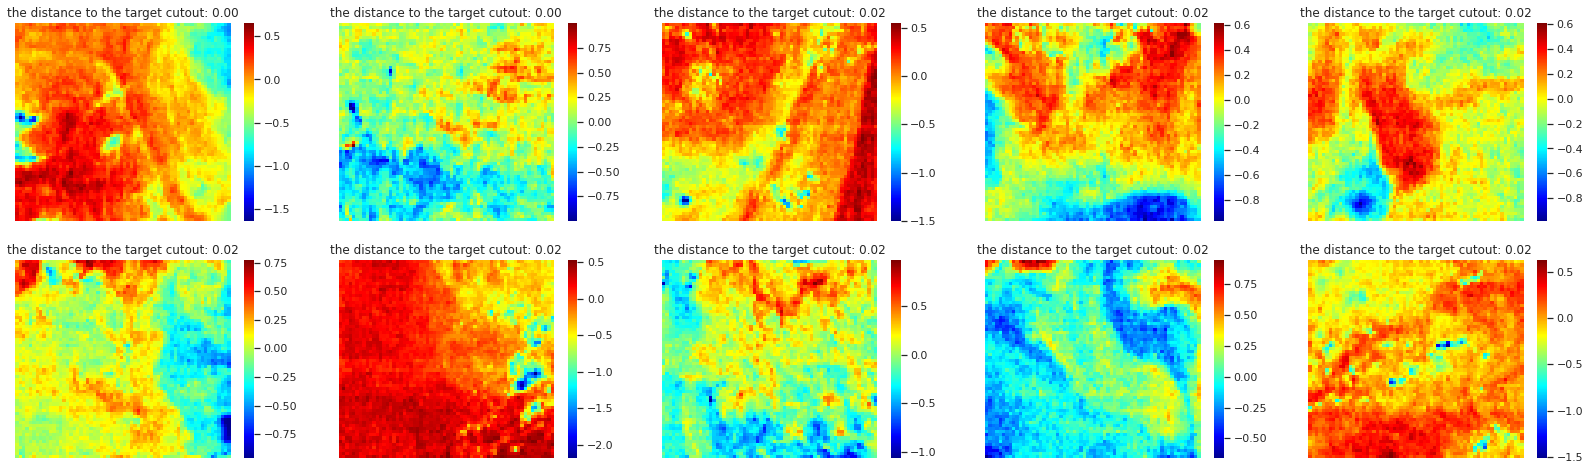

In [138]:
plt.figure(figsize=(28, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

### Show the set 4

In [139]:
imgs_set = modis_train[indice_sets[3]]
dist_set = dist_sets[3]

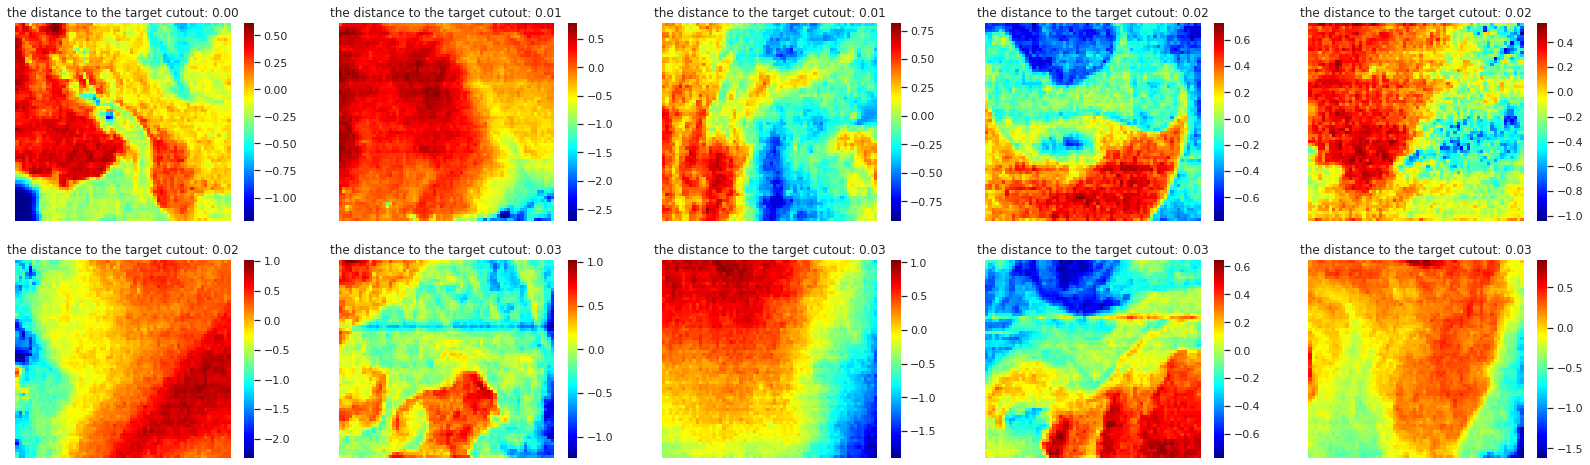

In [140]:
plt.figure(figsize=(28, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

### Show the set 5

In [144]:
imgs_set = modis_train[indice_sets[4]]
dist_set = dist_sets[4]

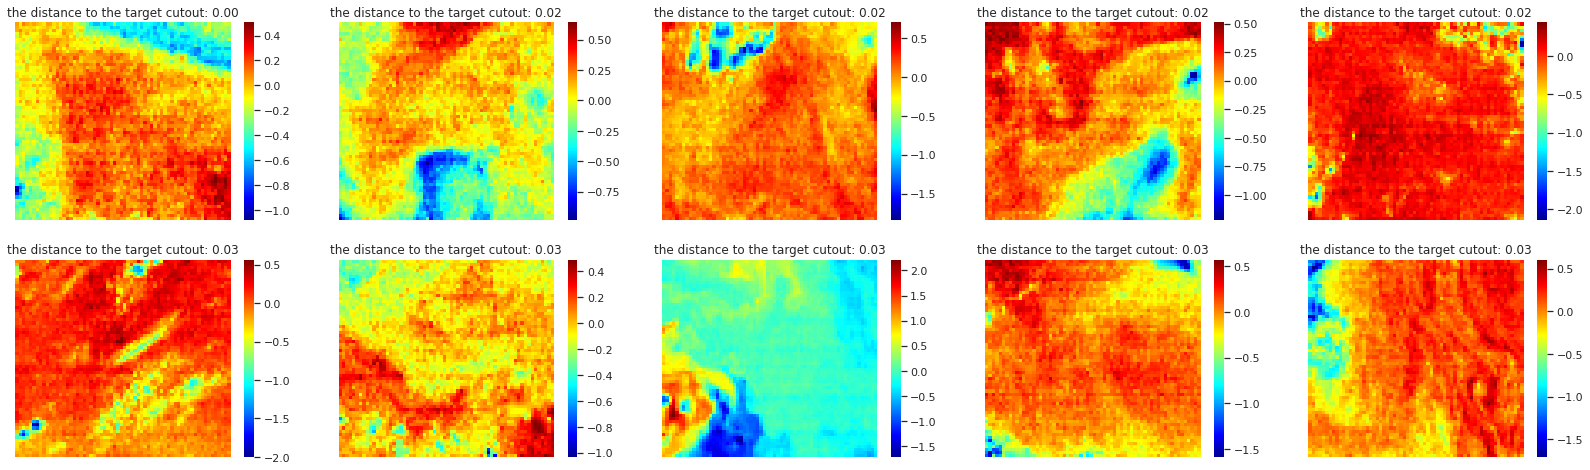

In [145]:
plt.figure(figsize=(28, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

## 5 Epochs result

In [257]:
### Load latents from s3
latents_epoch_5_file = 's3://modis-l2/modis_latents_simclr/modis_latents_ckpt_epoch_5.h5'
latents_epoch_5 = ulmo_io.load_to_bytes(latents_epoch_5_file)
with h5py.File(latents_epoch_5, 'r') as file:
    print(file.keys())
    latents_epoch_5 = file['modis_latents'][:]

<KeysViewHDF5 ['modis_latents']>


In [258]:
latents_epoch_5.shape

(134162, 128)

In [259]:
### Initialize the linear transformer at first
scaler = StandardScaler()
### Estimate the parameters
scaler.fit(latents_epoch_5)
### Transform the latents
latents_std = scaler.transform(latents_epoch_5)

In [153]:
### Let's use PCA at first to estimate the dimension of the main components. But before that, we want to standarize the latent vector
pca = PCA(n_components='mle', random_state=0)
pca.fit(latents_std)
singular_vals = pca.singular_values_

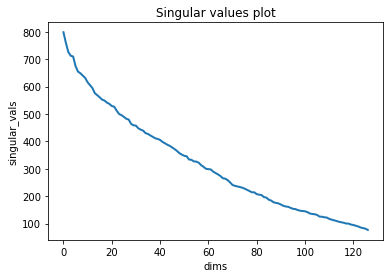

In [55]:
### plot the singular values to estimate the dimensions
plt.figure()
plt.title('Singular values plot')
plt.plot(singular_vals.squeeze(), linewidth=2)
plt.xlabel('dims')
plt.ylabel('singular_vals')
plt.show()

In [260]:
%%time
reducer_umap = umap.UMAP()
latents_mapping = reducer_umap.fit(latents_std)

CPU times: user 14min 42s, sys: 3min 23s, total: 18min 6s
Wall time: 3min 7s


<AxesSubplot:>

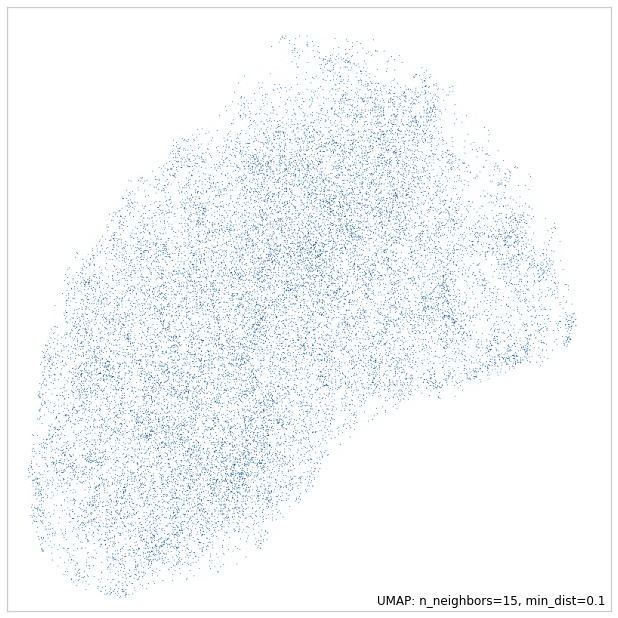

In [252]:
umap.plot.points(latents_mapping)

<AxesSubplot:>

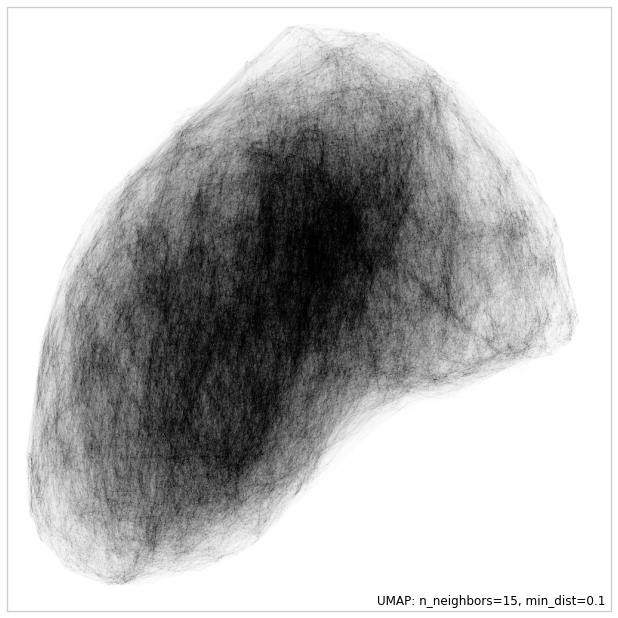

In [261]:
umap.plot.connectivity(latents_mapping, show_points=False)

In [154]:
%%time
reducer_umap = umap.UMAP()
latents_embedding = reducer_umap.fit_transform(latents_std)

CPU times: user 13min 14s, sys: 3min 32s, total: 16min 46s
Wall time: 2min 55s


In [155]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(latents_embedding)

In [156]:
distances, indices = nbrs.kneighbors(latents_embedding)

In [157]:
### fix seed
np.random.seed(0)
indice_sampled = np.random.choice(indices.shape[0], 5)
indice_sets = indices[indice_array]
dist_sets = distances[indice_array]

In [158]:
imgs_set = modis_train[indice_sets[0]]
dist_set = dist_sets[0]

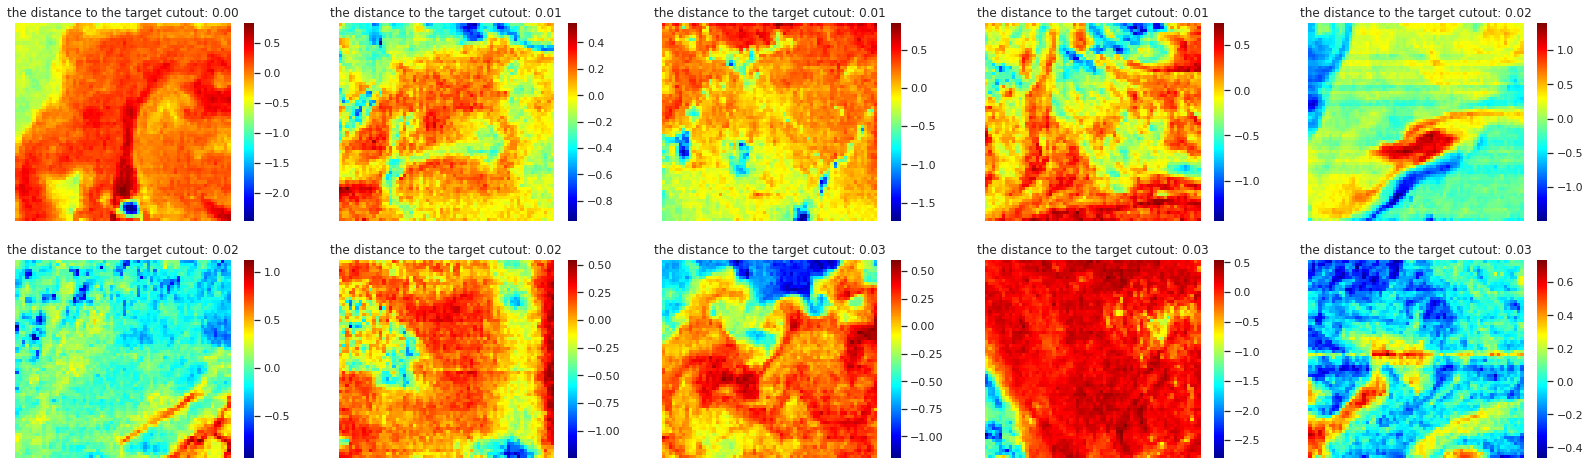

In [159]:
plt.figure(figsize=(28, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [160]:
imgs_set = modis_train[indice_sets[1]]
dist_set = dist_sets[1]

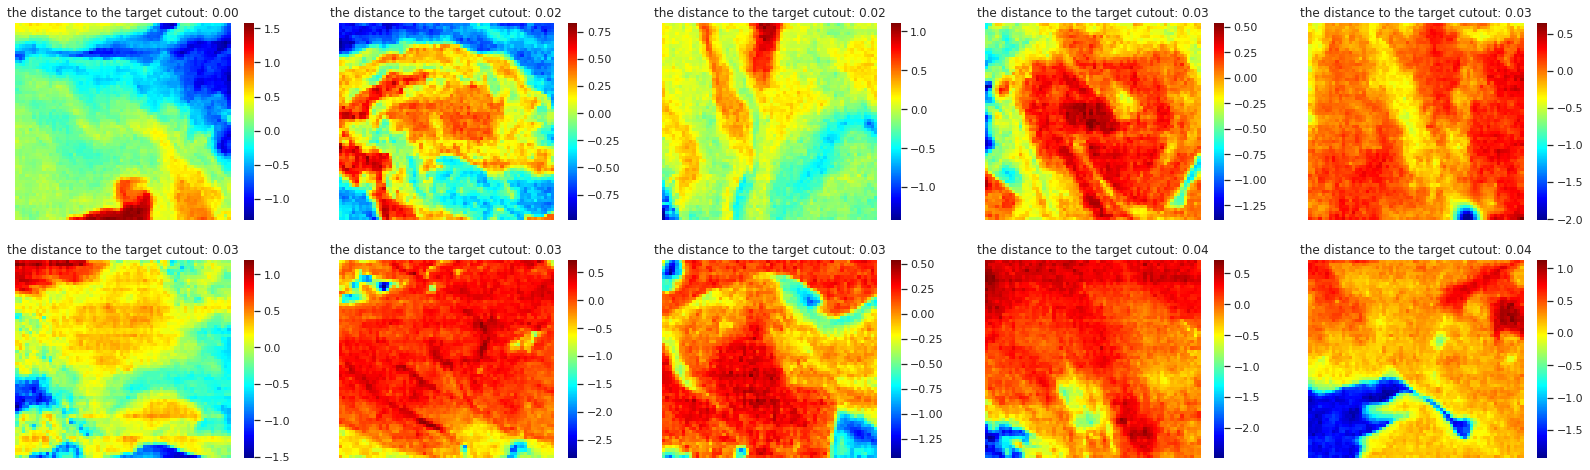

In [161]:
plt.figure(figsize=(28, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [162]:
imgs_set = modis_train[indice_sets[2]]
dist_set = dist_sets[2]

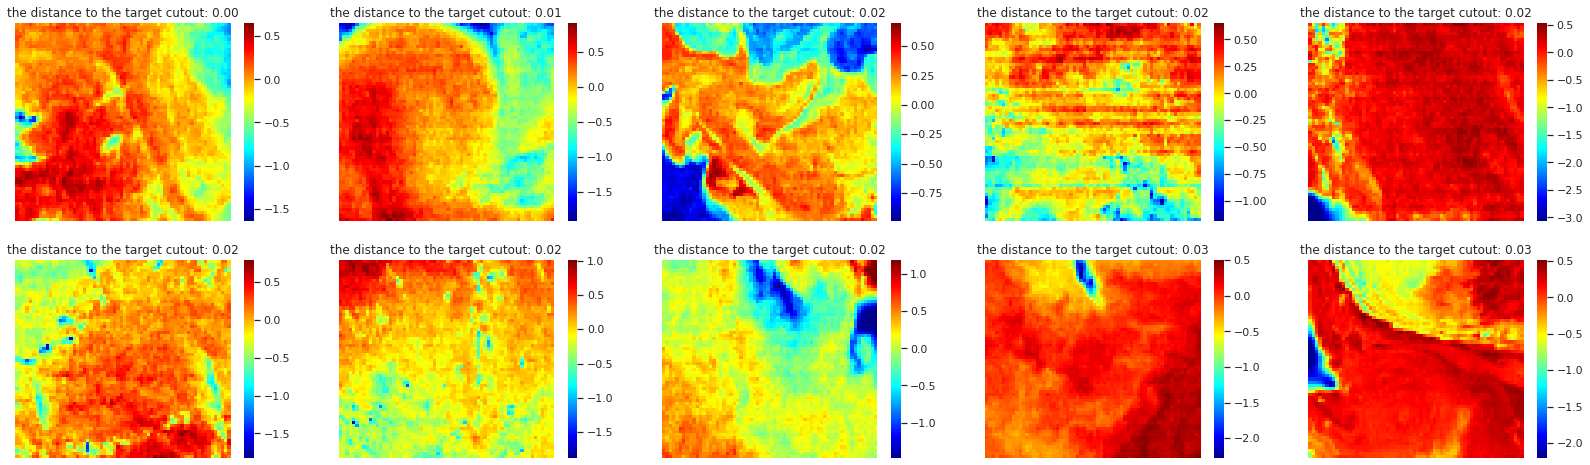

In [163]:
plt.figure(figsize=(28, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [164]:
imgs_set = modis_train[indice_sets[3]]
dist_set = dist_sets[3]

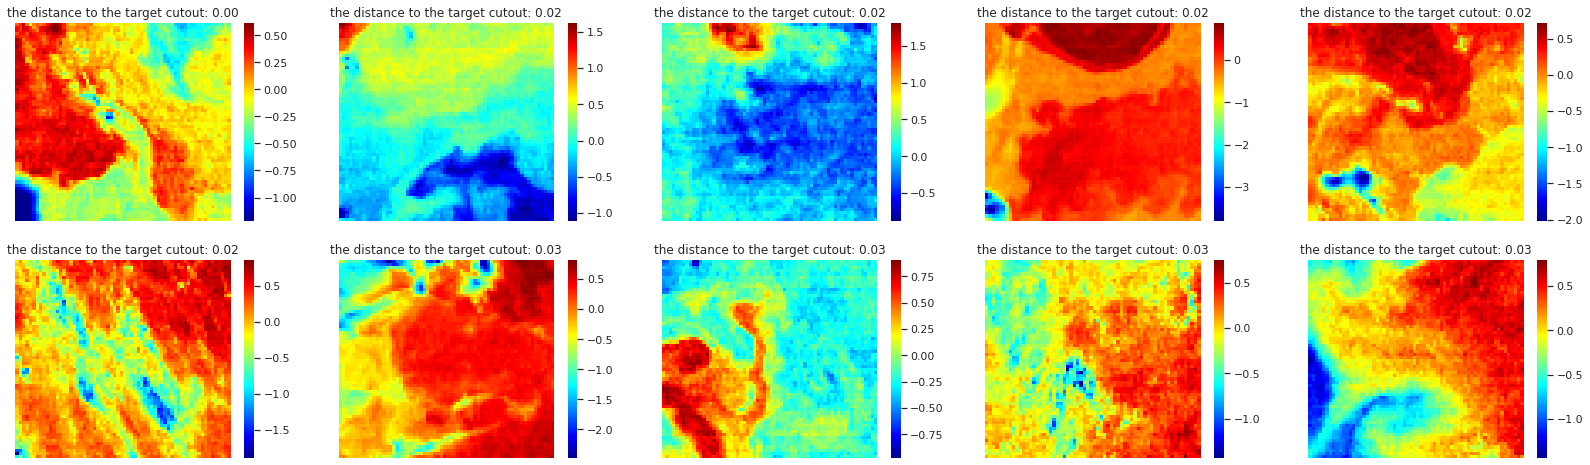

In [165]:
plt.figure(figsize=(28, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [166]:
imgs_set = modis_train[indice_sets[4]]
dist_set = dist_sets[4]

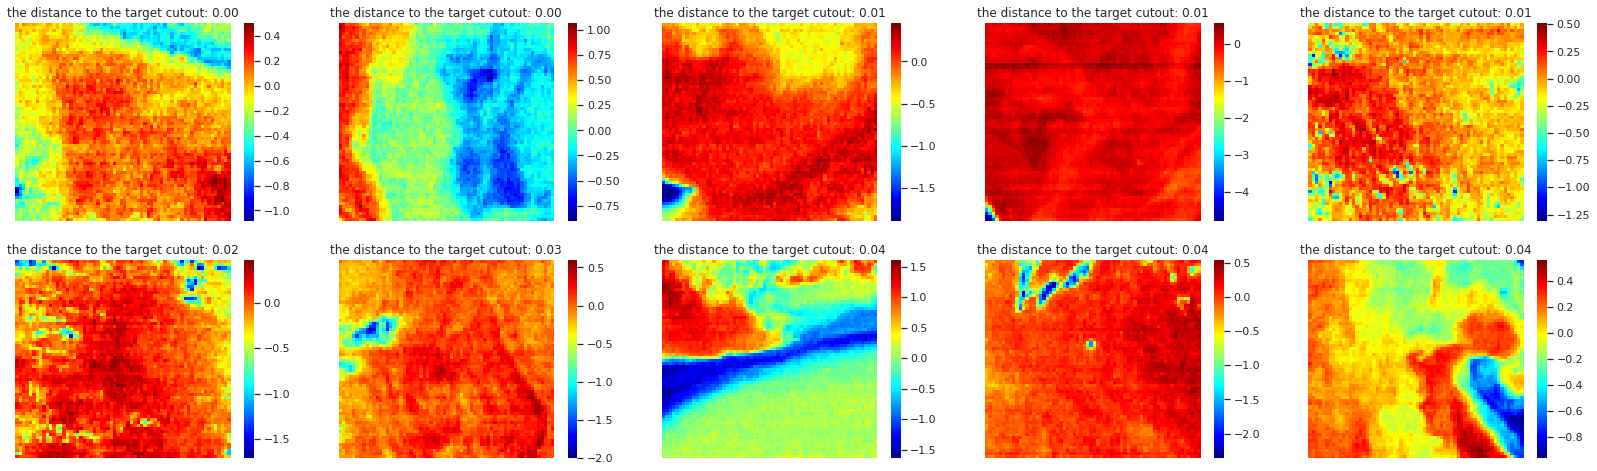

In [168]:
plt.figure(figsize=(28, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [169]:
dist_sets = distances[220]
nearest_imgs = modis_train[indices[220]]

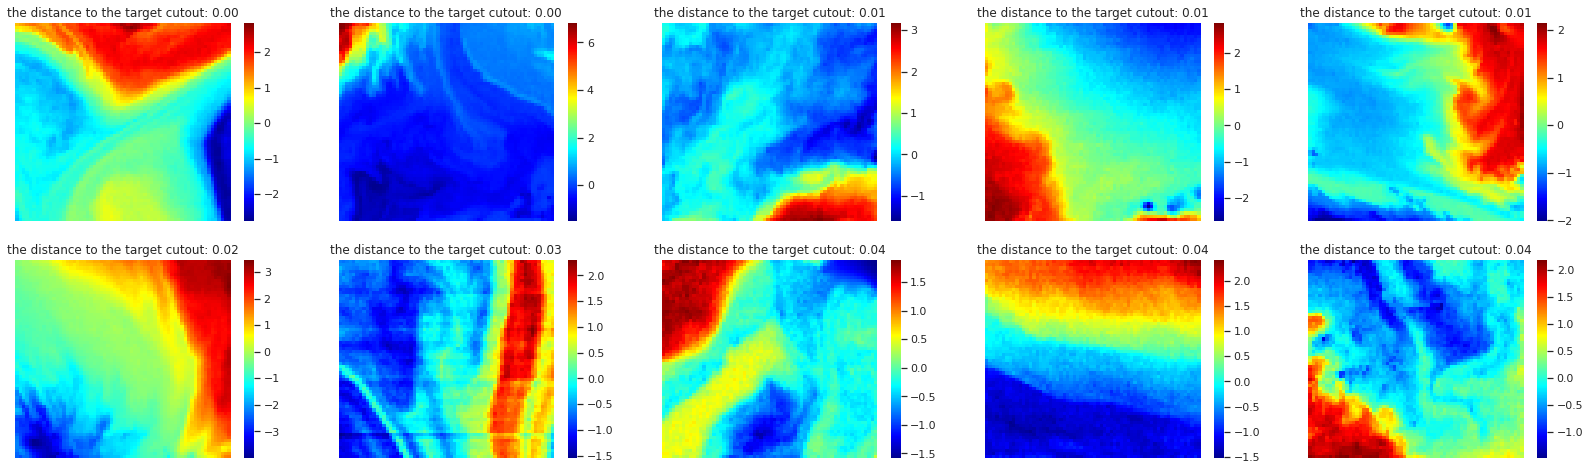

In [171]:
plt.figure(figsize=(28, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.heatmap(nearest_imgs[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [172]:
dist_sets = distances[430]
nearest_imgs = modis_train[indices[430]]

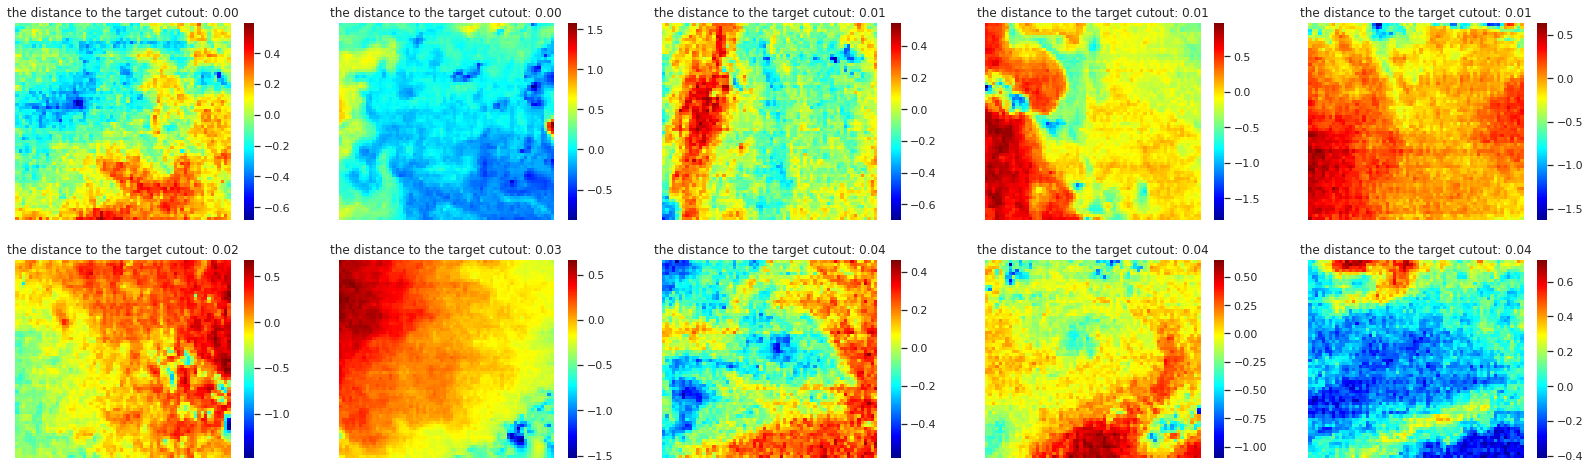

In [173]:
plt.figure(figsize=(28, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.heatmap(nearest_imgs[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [178]:
nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(latents_embedding)

In [179]:
distances, indices = nbrs.kneighbors(latents_embedding)

In [182]:
dist_set = distances[220]
nearest_imgs = modis_train[indices[220]]

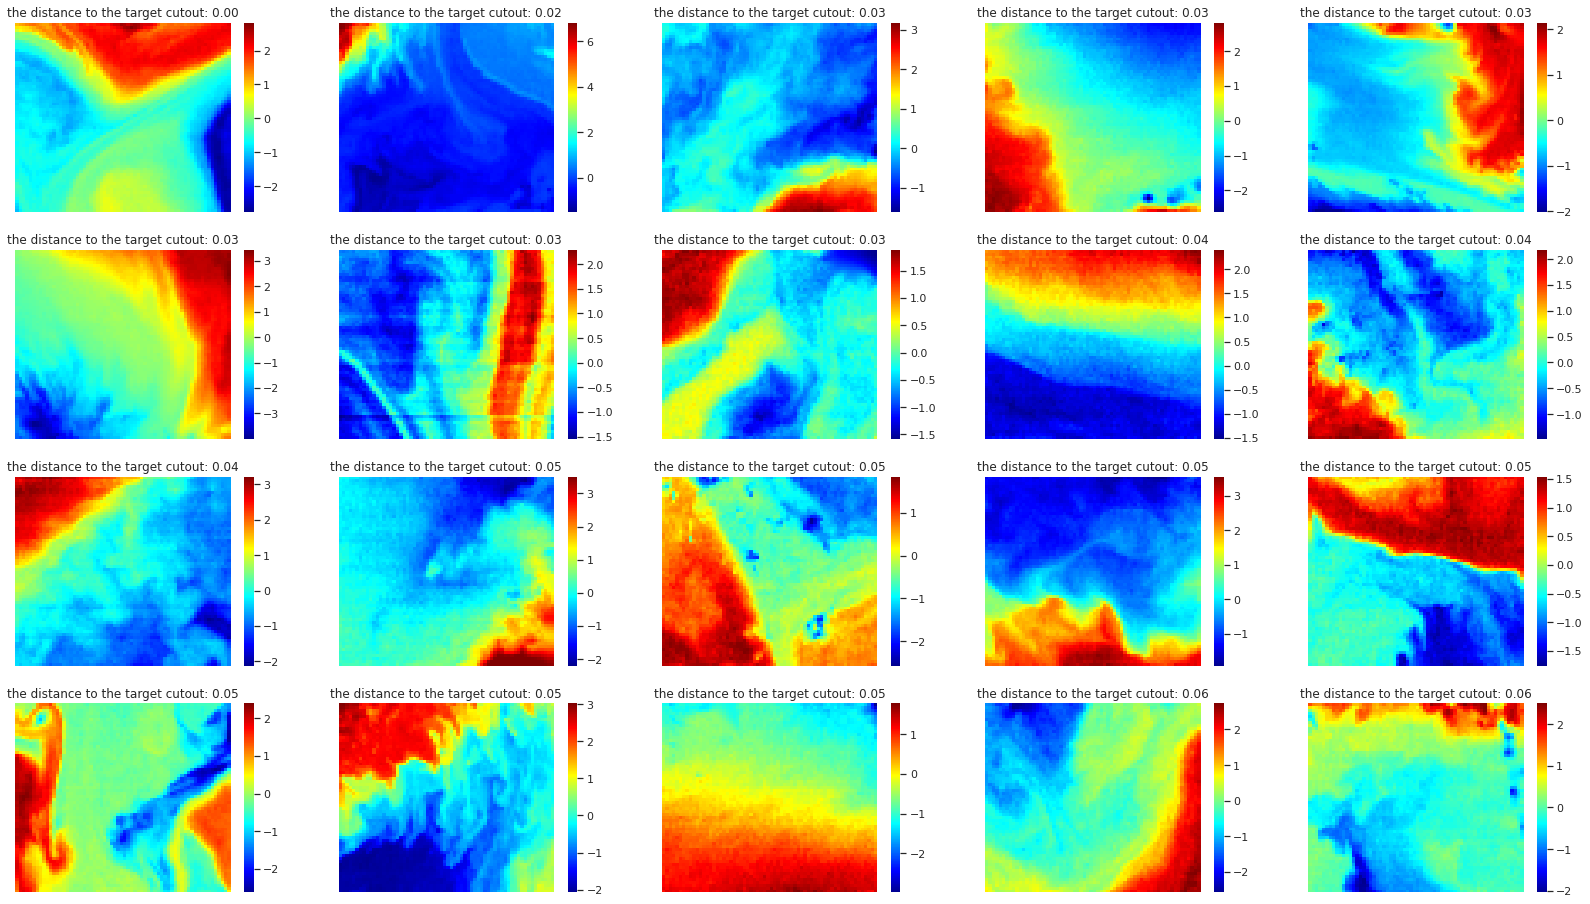

In [183]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(nearest_imgs[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [184]:
nbrs = NearestNeighbors(n_neighbors=30, algorithm='ball_tree').fit(latents_embedding)

In [185]:
distances, indices = nbrs.kneighbors(latents_embedding)

In [186]:
dist_set = distances[220]
nearest_imgs = modis_train[indices[220]]

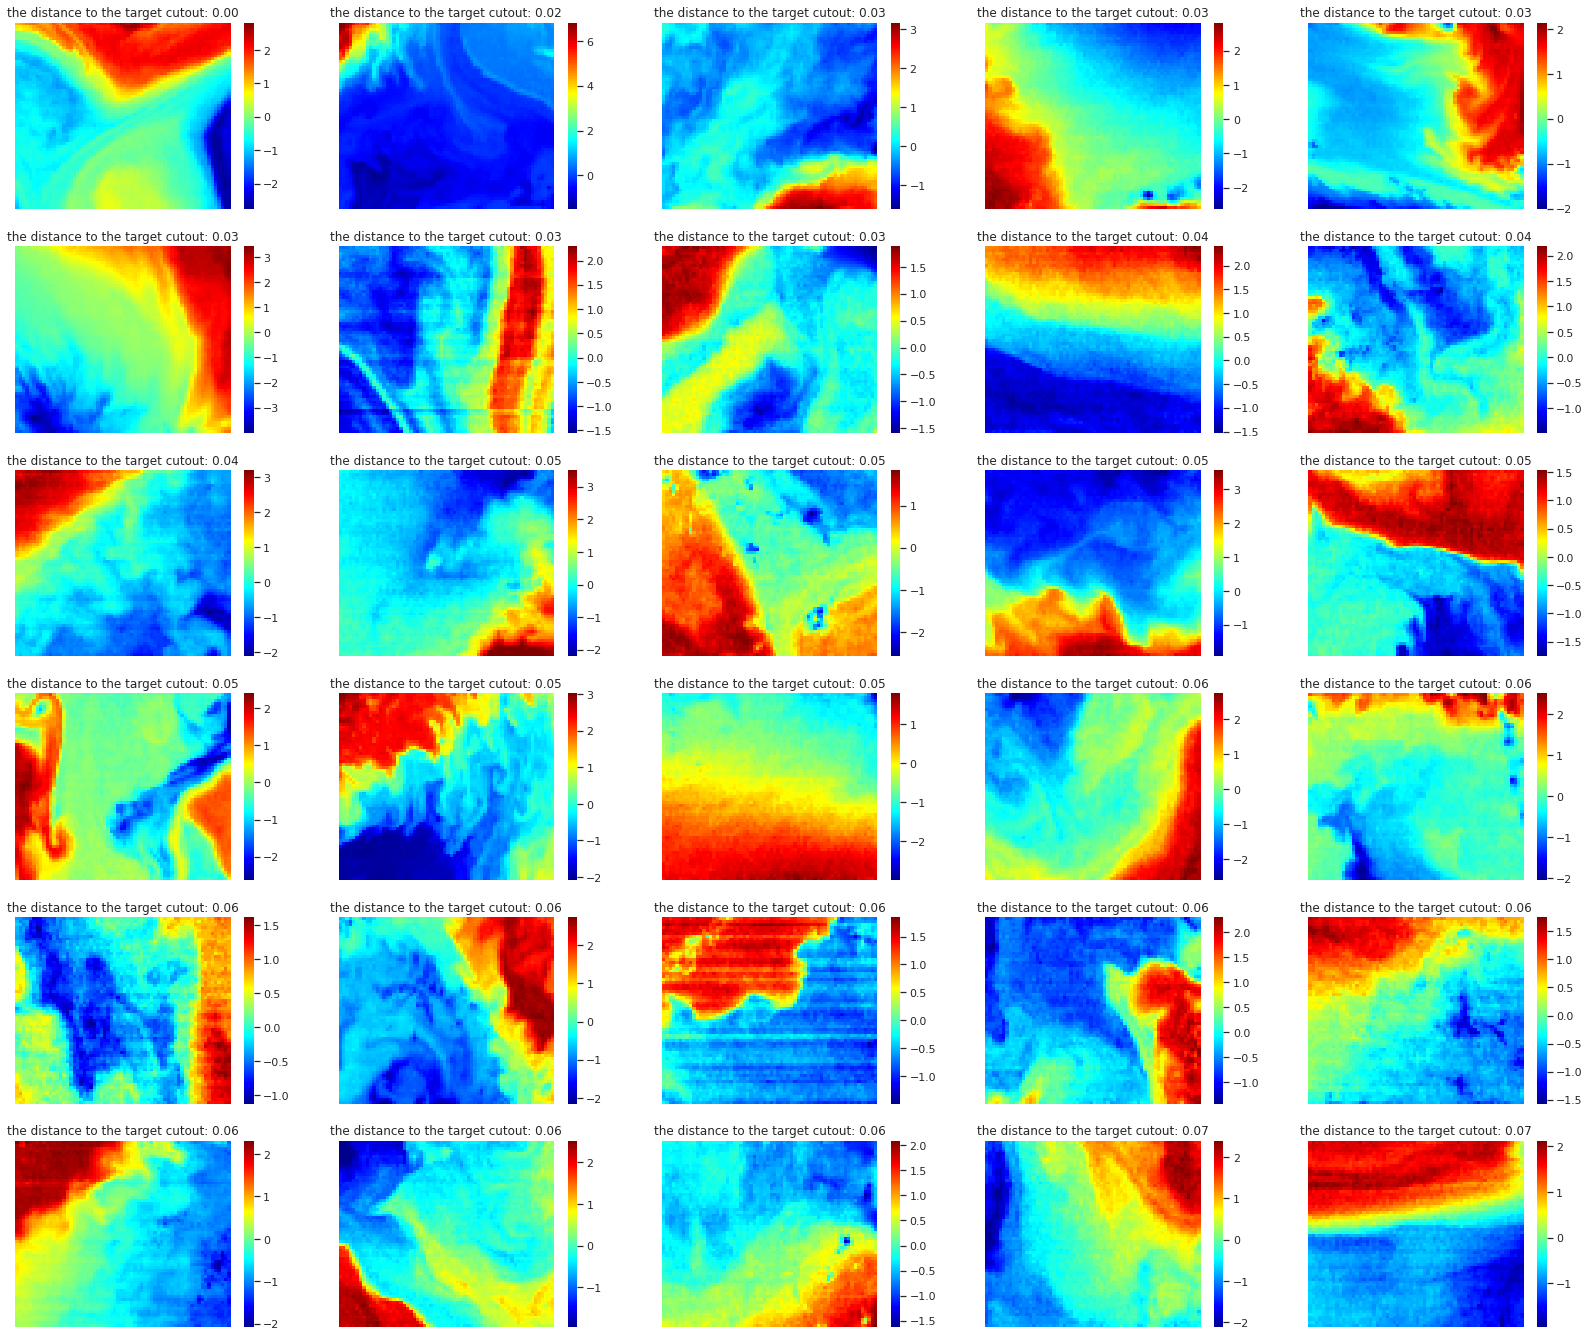

In [187]:
plt.figure(figsize=(28, 24))
for i in range(30):
    plt.subplot(6, 5, i+1)
    sns.heatmap(nearest_imgs[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

## 10 Epochs result

In [262]:
### Load latents from s3
latents_epoch_10_file = 's3://modis-l2/modis_latents_simclr/modis_latents_ckpt_epoch_10.h5'
latents_epoch_10 = ulmo_io.load_to_bytes(latents_epoch_10_file)
with h5py.File(latents_epoch_10, 'r') as file:
    print(file.keys())
    latents_epoch_10 = file['modis_latents'][:]

<KeysViewHDF5 ['modis_latents']>


In [263]:
latents_epoch_10.shape

(134162, 128)

In [264]:
### Initialize the linear transformer at first
scaler = StandardScaler()
### Estimate the parameters
scaler.fit(latents_epoch_10)
### Transform the latents
latents_std = scaler.transform(latents_epoch_10)

In [193]:
### Let's use PCA at first to estimate the dimension of the main components. But before that, we want to standarize the latent vector
pca = PCA(n_components='mle', random_state=0)
pca.fit(latents_std)
singular_vals = pca.singular_values_

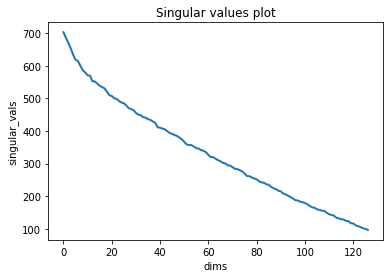

In [64]:
### plot the singular values to estimate the dimensions
plt.figure()
plt.title('Singular values plot')
plt.plot(singular_vals.squeeze(), linewidth=2)
plt.xlabel('dims')
plt.ylabel('singular_vals')
plt.show()

In [265]:
%%time
reducer_umap = umap.UMAP()
latents_mapping = reducer_umap.fit(latents_std)

CPU times: user 17min 23s, sys: 3min 42s, total: 21min 6s
Wall time: 3min 36s


<AxesSubplot:>

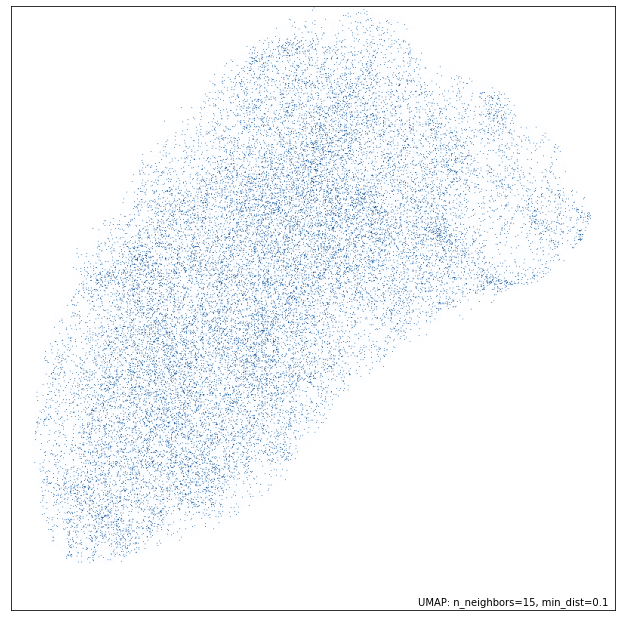

In [66]:
umap.plot.points(latents_mapping)

<AxesSubplot:>

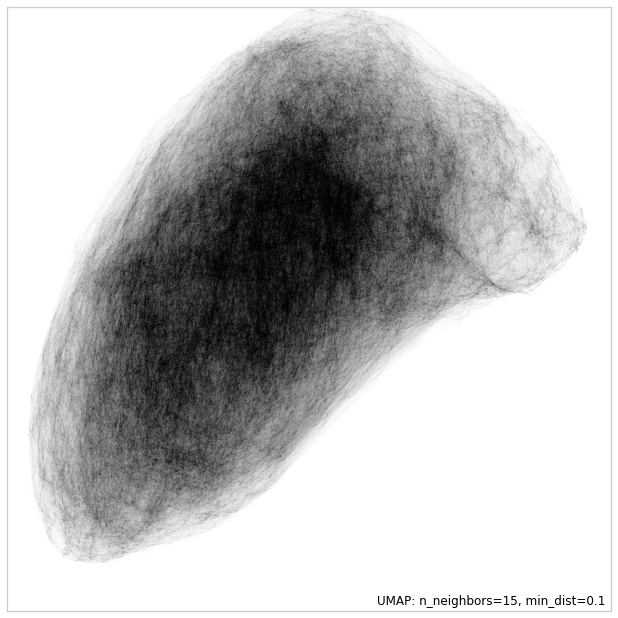

In [266]:
umap.plot.connectivity(latents_mapping, show_points=False)

In [194]:
%%time
reducer_umap = umap.UMAP()
latents_embedding = reducer_umap.fit_transform(latents_std)

CPU times: user 12min 44s, sys: 3min 24s, total: 16min 8s
Wall time: 2min 49s


In [195]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(latents_embedding)

In [196]:
distances, indices = nbrs.kneighbors(latents_embedding)

In [197]:
dist_sets = distances[220]
nearest_imgs = modis_train[indices[220]]

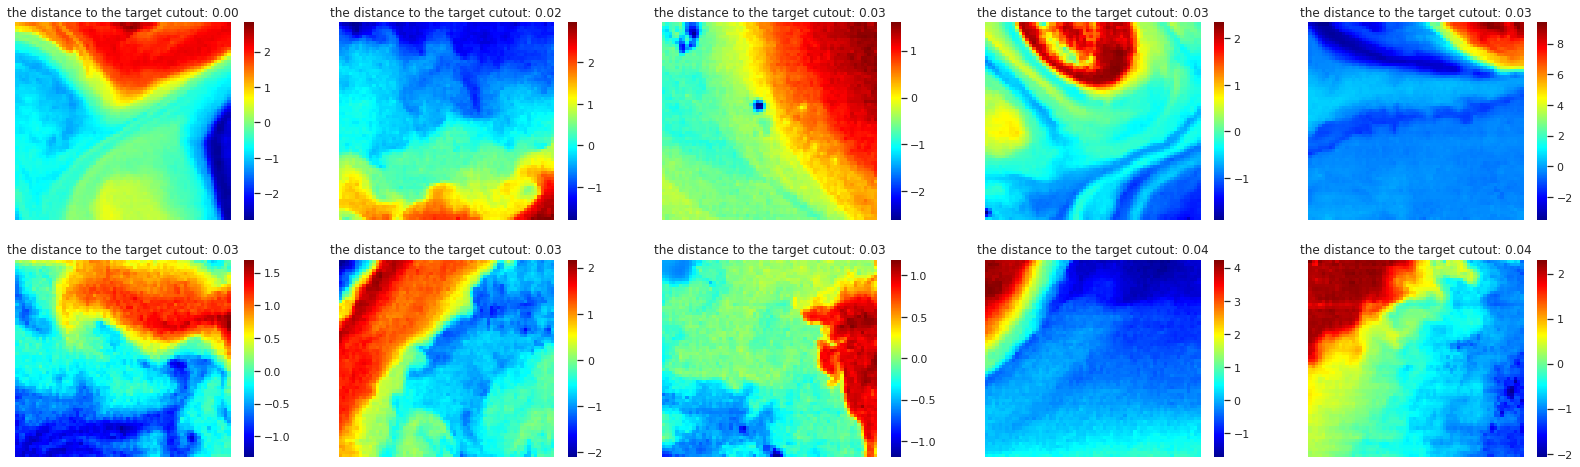

In [198]:
plt.figure(figsize=(28, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.heatmap(nearest_imgs[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [199]:
nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(latents_embedding)

In [200]:
distances, indices = nbrs.kneighbors(latents_embedding)

In [202]:
dist_set = distances[220]
nearest_imgs = modis_train[indices[220]]

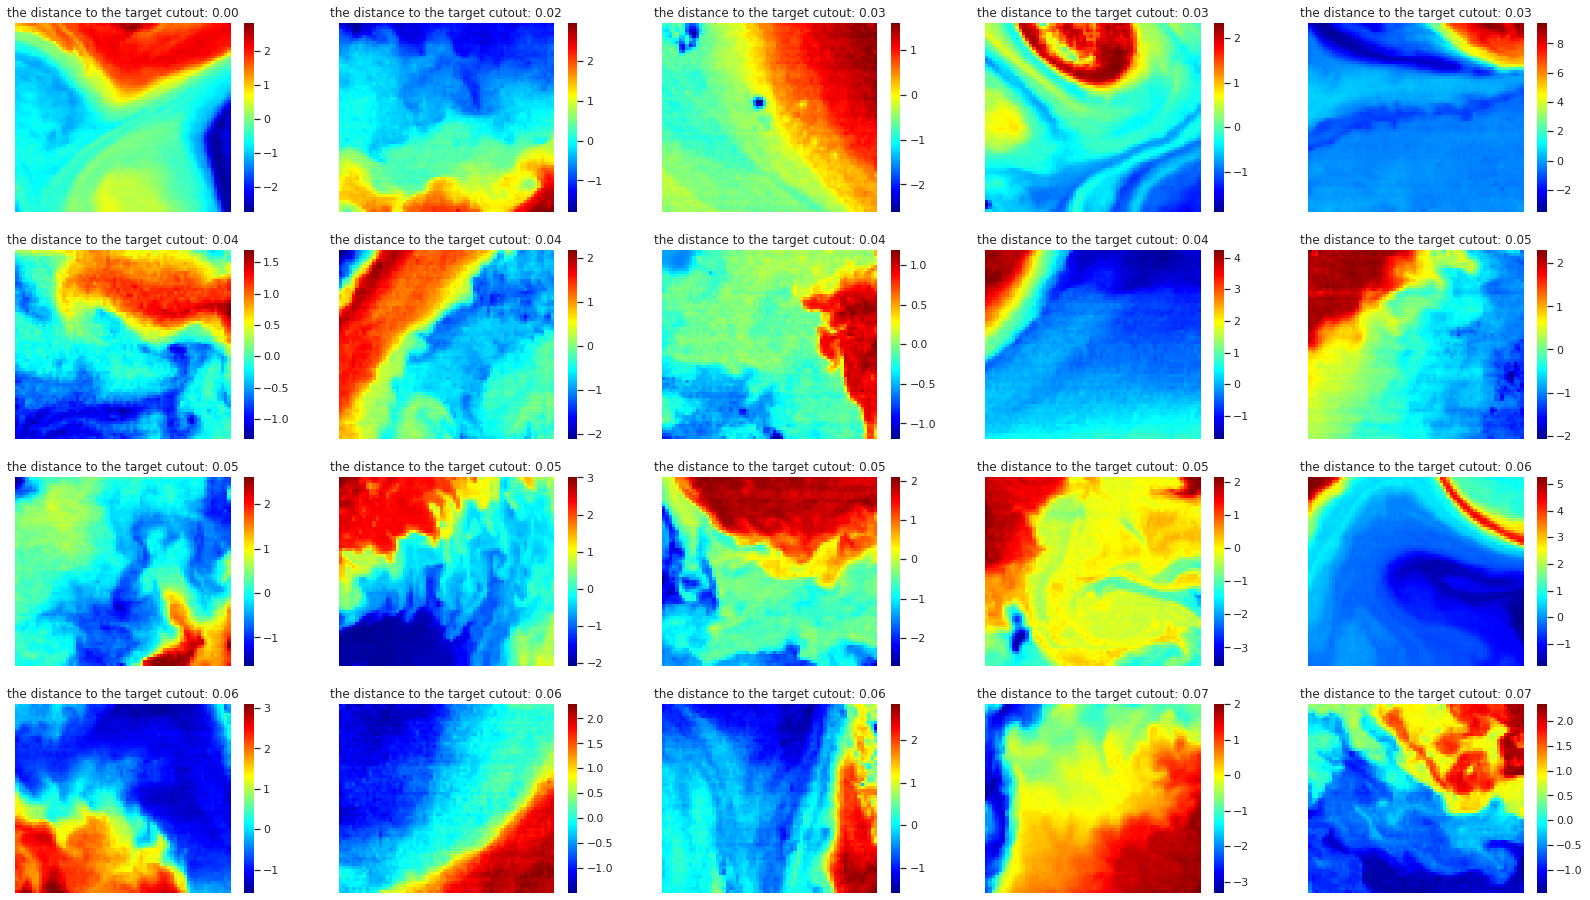

In [203]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(nearest_imgs[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [204]:
nbrs = NearestNeighbors(n_neighbors=40, algorithm='ball_tree').fit(latents_embedding)

In [205]:
distances, indices = nbrs.kneighbors(latents_embedding)

In [206]:
dist_set = distances[220]
nearest_imgs = modis_train[indices[220]]

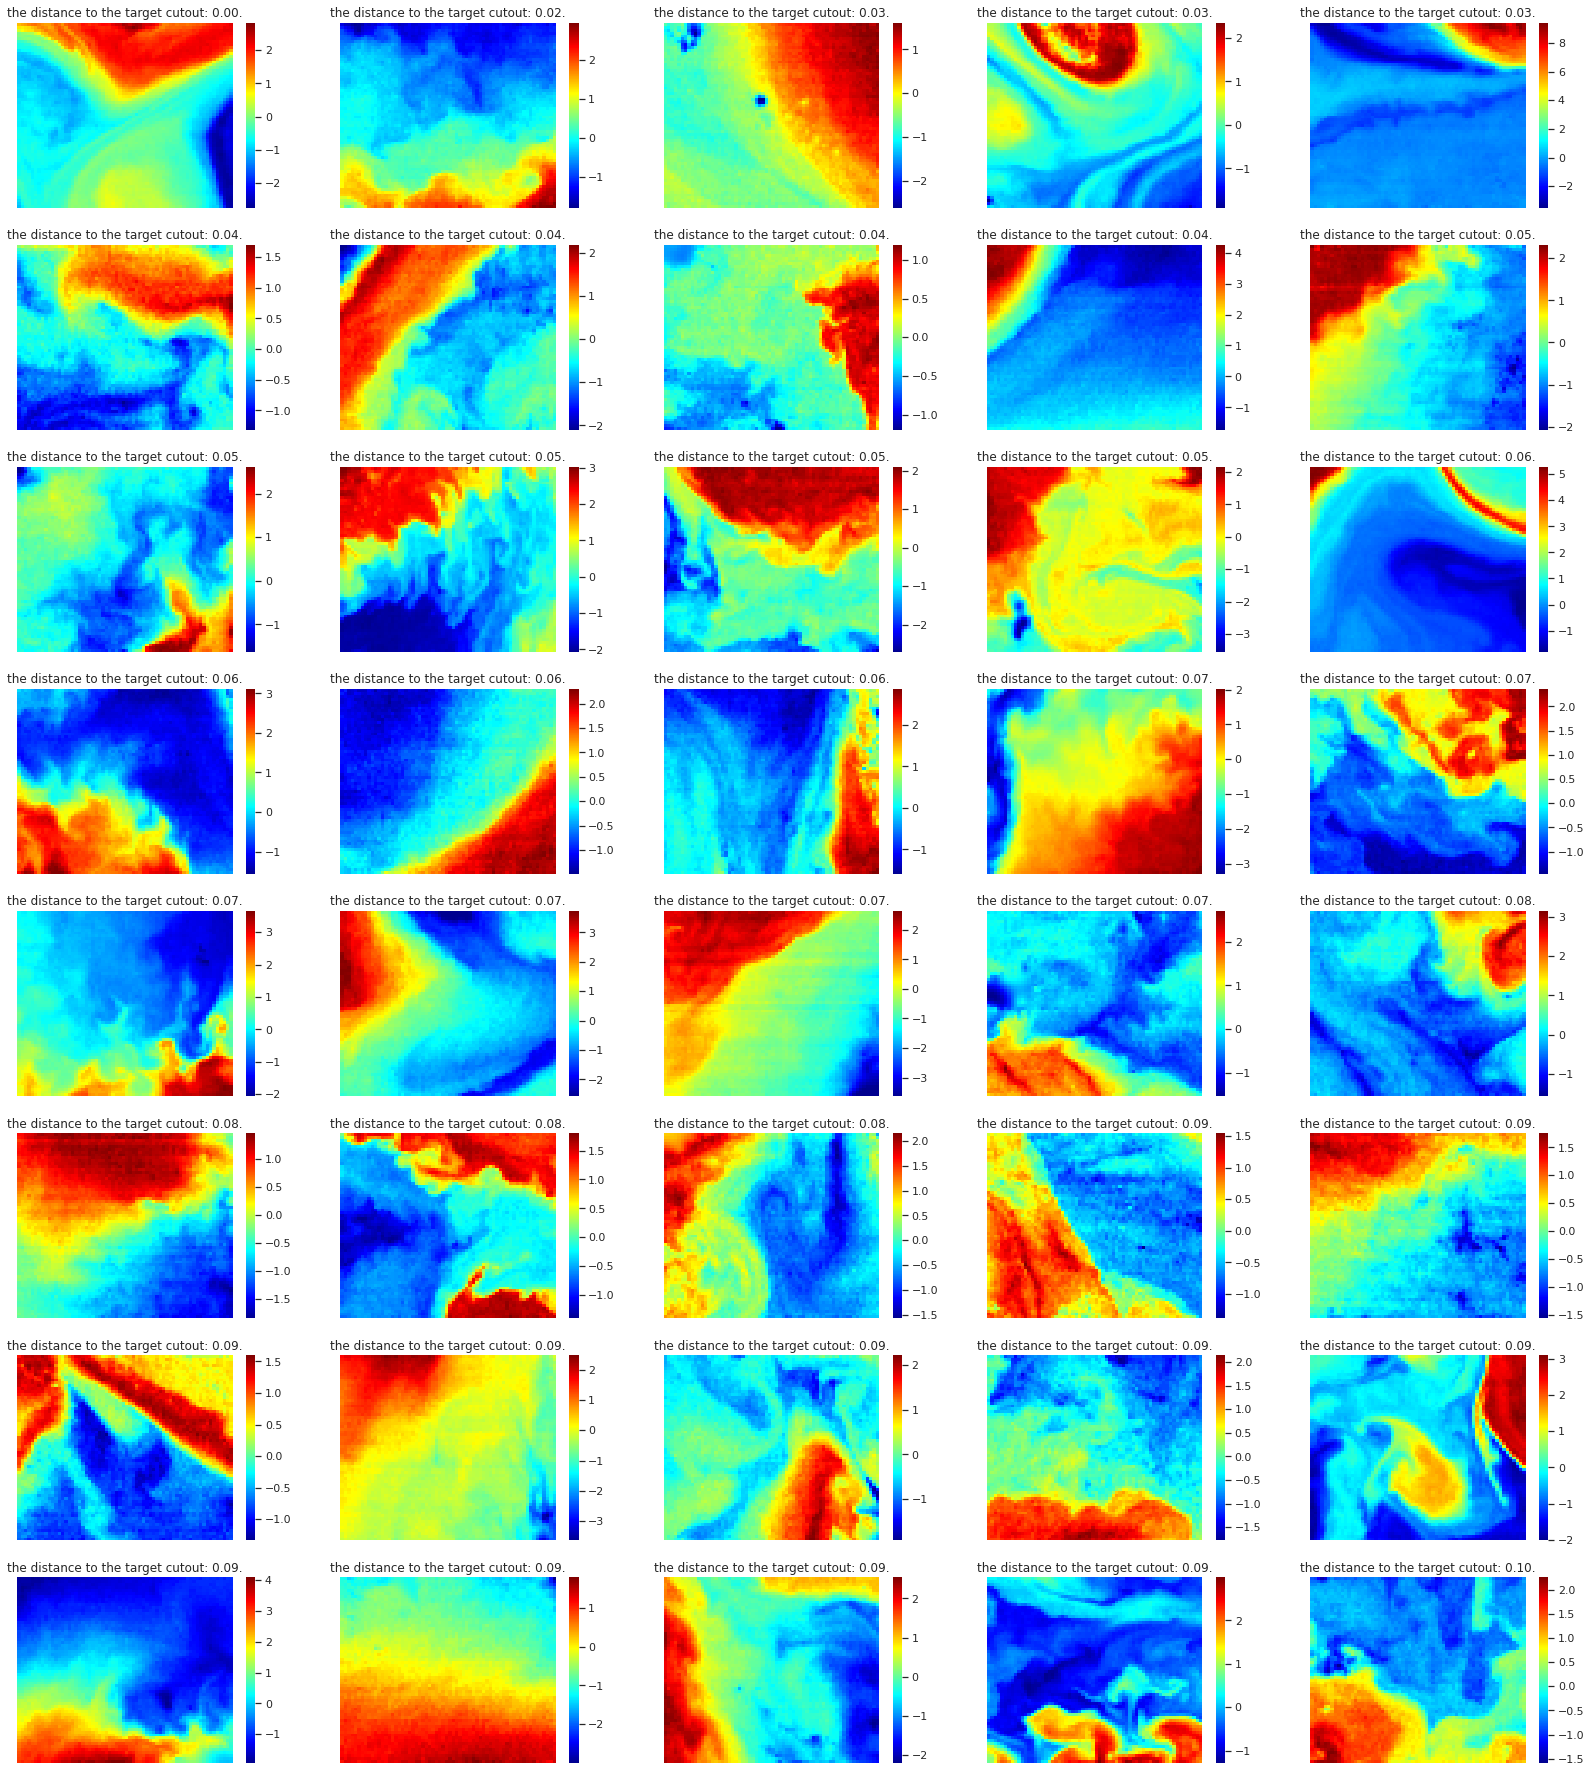

In [213]:
plt.figure(figsize=(28, 32))
for i in range(40):
    plt.subplot(8, 5, i+1)
    sns.heatmap(nearest_imgs[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}.')

## 15 Epochs result

In [214]:
### Load latents from s3
latents_epoch_15_file = 's3://modis-l2/modis_latents_simclr/modis_latents_ckpt_epoch_15.h5'
latents_epoch_15 = ulmo_io.load_to_bytes(latents_epoch_15_file)
with h5py.File(latents_epoch_15, 'r') as file:
    print(file.keys())
    latents_epoch_15 = file['modis_latents'][:]

<KeysViewHDF5 ['modis_latents']>


In [215]:
### Initialize the linear transformer at first
scaler = StandardScaler()
### Estimate the parameters
scaler.fit(latents_epoch_15)
### Transform the latents
latents_std = scaler.transform(latents_epoch_15)

In [216]:
### Let's use PCA at first to estimate the dimension of the main components. But before that, we want to standarize the latent vector
pca = PCA(n_components='mle', random_state=0)
pca.fit(latents_std)
singular_vals = pca.singular_values_

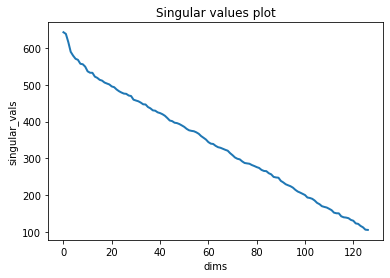

In [80]:
### plot the singular values to estimate the dimensions
plt.figure()
plt.title('Singular values plot')
plt.plot(singular_vals.squeeze(), linewidth=2)
plt.xlabel('dims')
plt.ylabel('singular_vals')
plt.show()

In [217]:
%%time
reducer_umap = umap.UMAP()
latents_mapping = reducer_umap.fit(latents_std)

CPU times: user 14min 12s, sys: 3min 34s, total: 17min 46s
Wall time: 3min 5s


<AxesSubplot:>

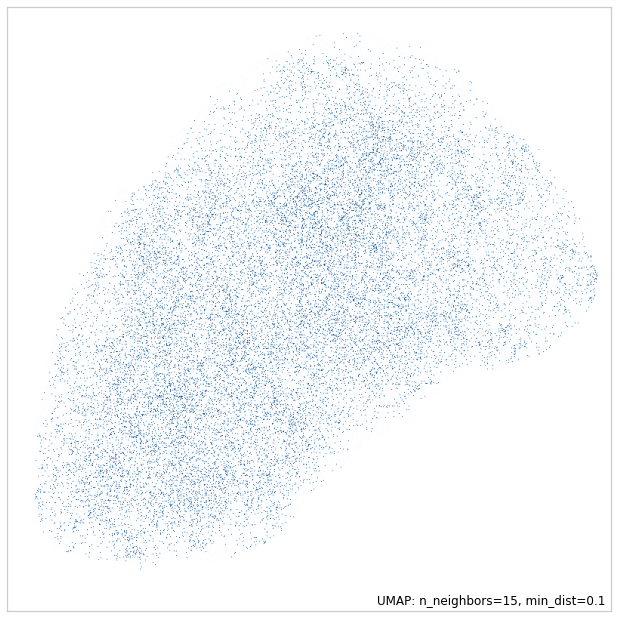

In [218]:
umap.plot.points(latents_mapping)

<AxesSubplot:>

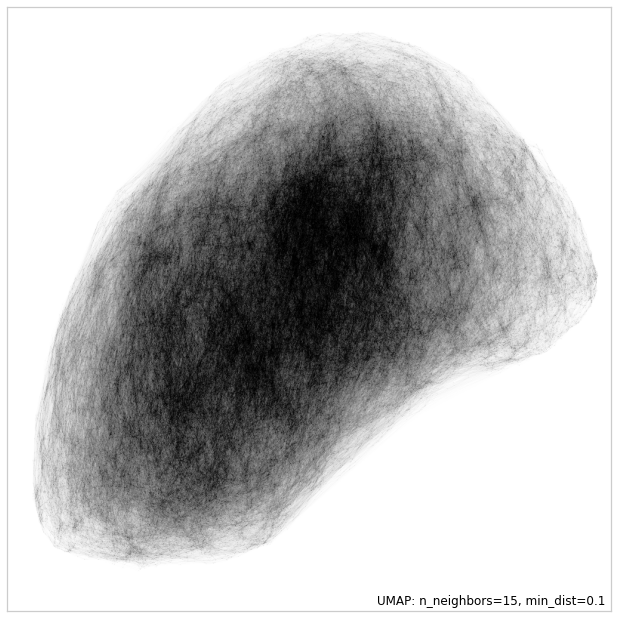

In [233]:
umap.plot.connectivity(latents_mapping, show_points=False)

In [219]:
%%time
reducer_umap = umap.UMAP()
latents_embedding = reducer_umap.fit_transform(latents_std)

CPU times: user 13min 28s, sys: 3min 46s, total: 17min 15s
Wall time: 2min 58s


In [221]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(latents_embedding)

In [222]:
distances, indices = nbrs.kneighbors(latents_embedding)

In [223]:
dist_sets = distances[220]
nearest_imgs = modis_train[indices[220]]

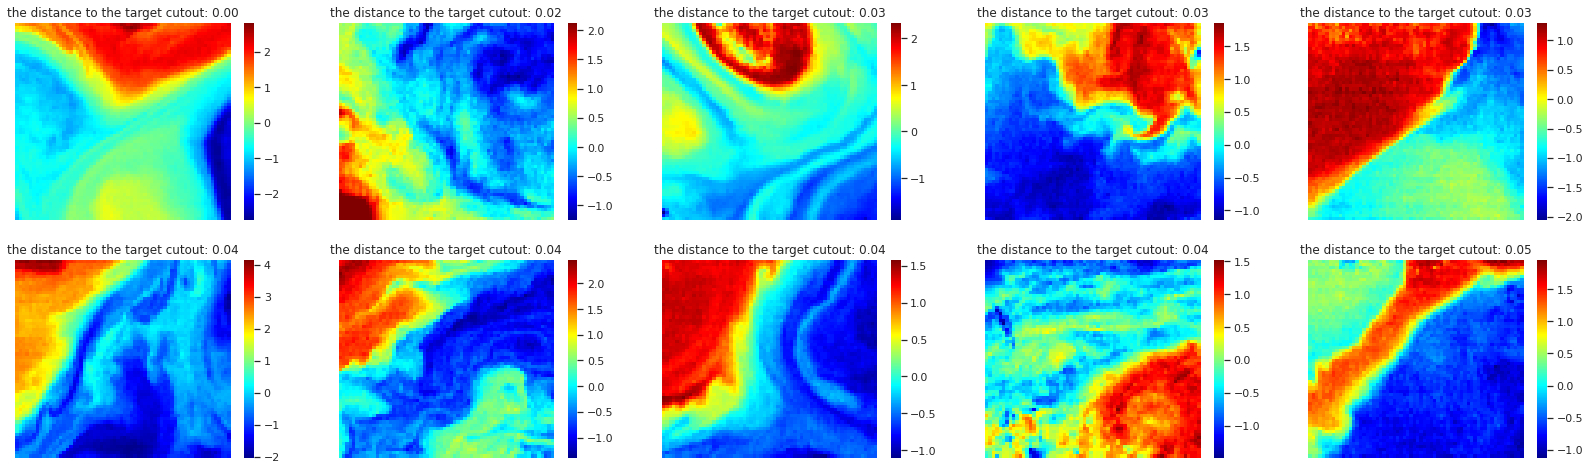

In [224]:
plt.figure(figsize=(28, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.heatmap(nearest_imgs[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [225]:
nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(latents_embedding)

In [226]:
distances, indices = nbrs.kneighbors(latents_embedding)

In [227]:
dist_sets = distances[220]
nearest_imgs = modis_train[indices[220]]

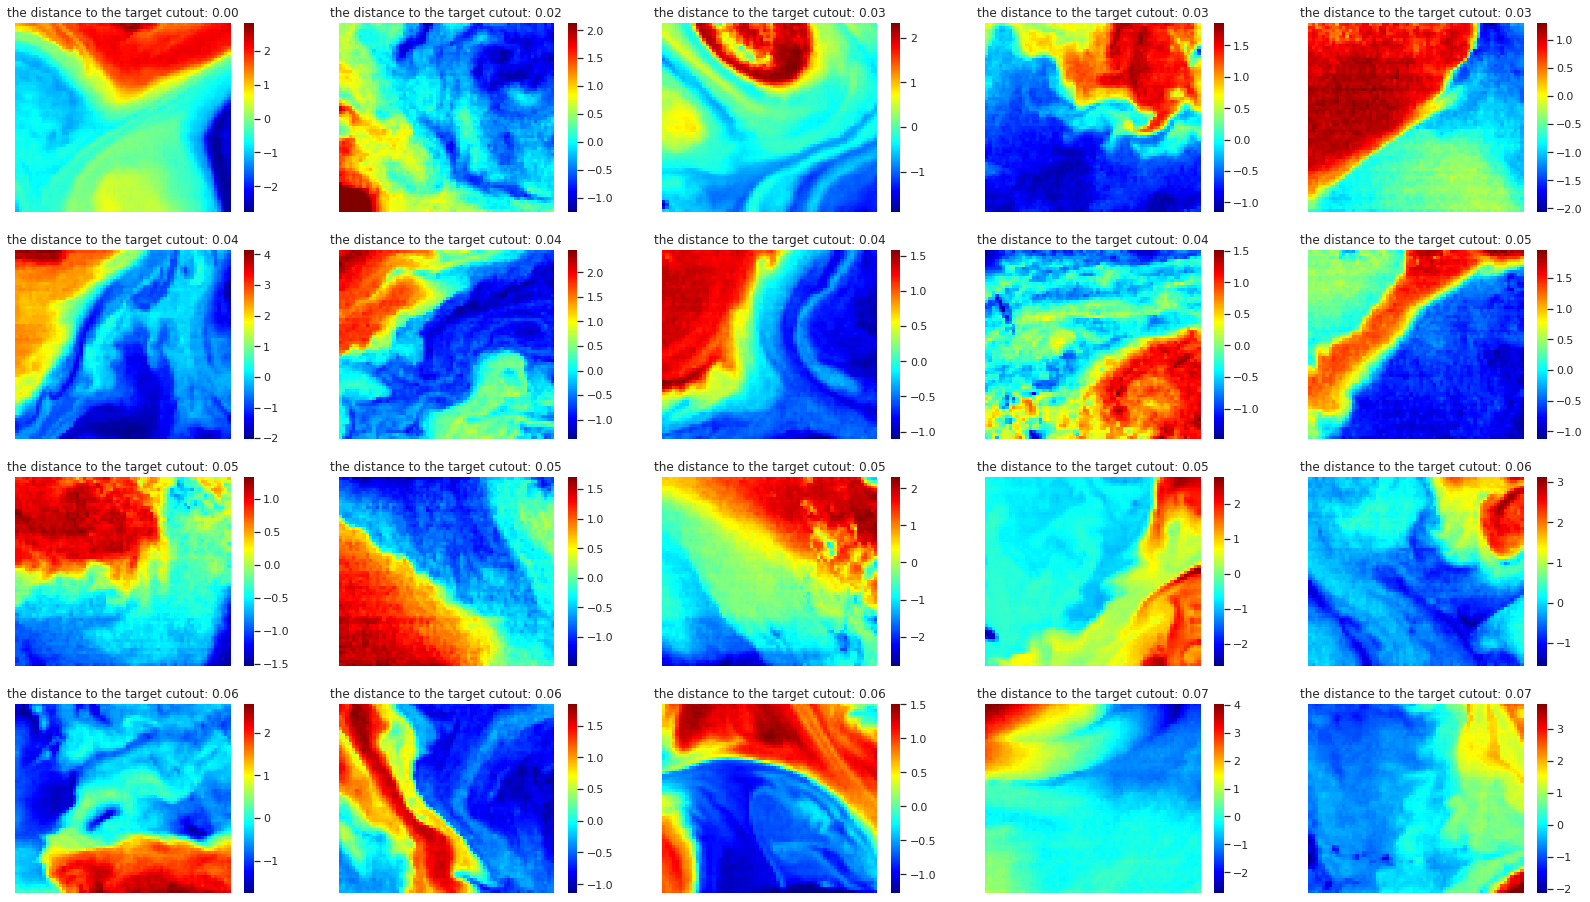

In [228]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(nearest_imgs[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [229]:
nbrs = NearestNeighbors(n_neighbors=40, algorithm='ball_tree').fit(latents_embedding)

In [230]:
distances, indices = nbrs.kneighbors(latents_embedding)

In [231]:
dist_sets = distances[220]
nearest_imgs = modis_train[indices[220]]

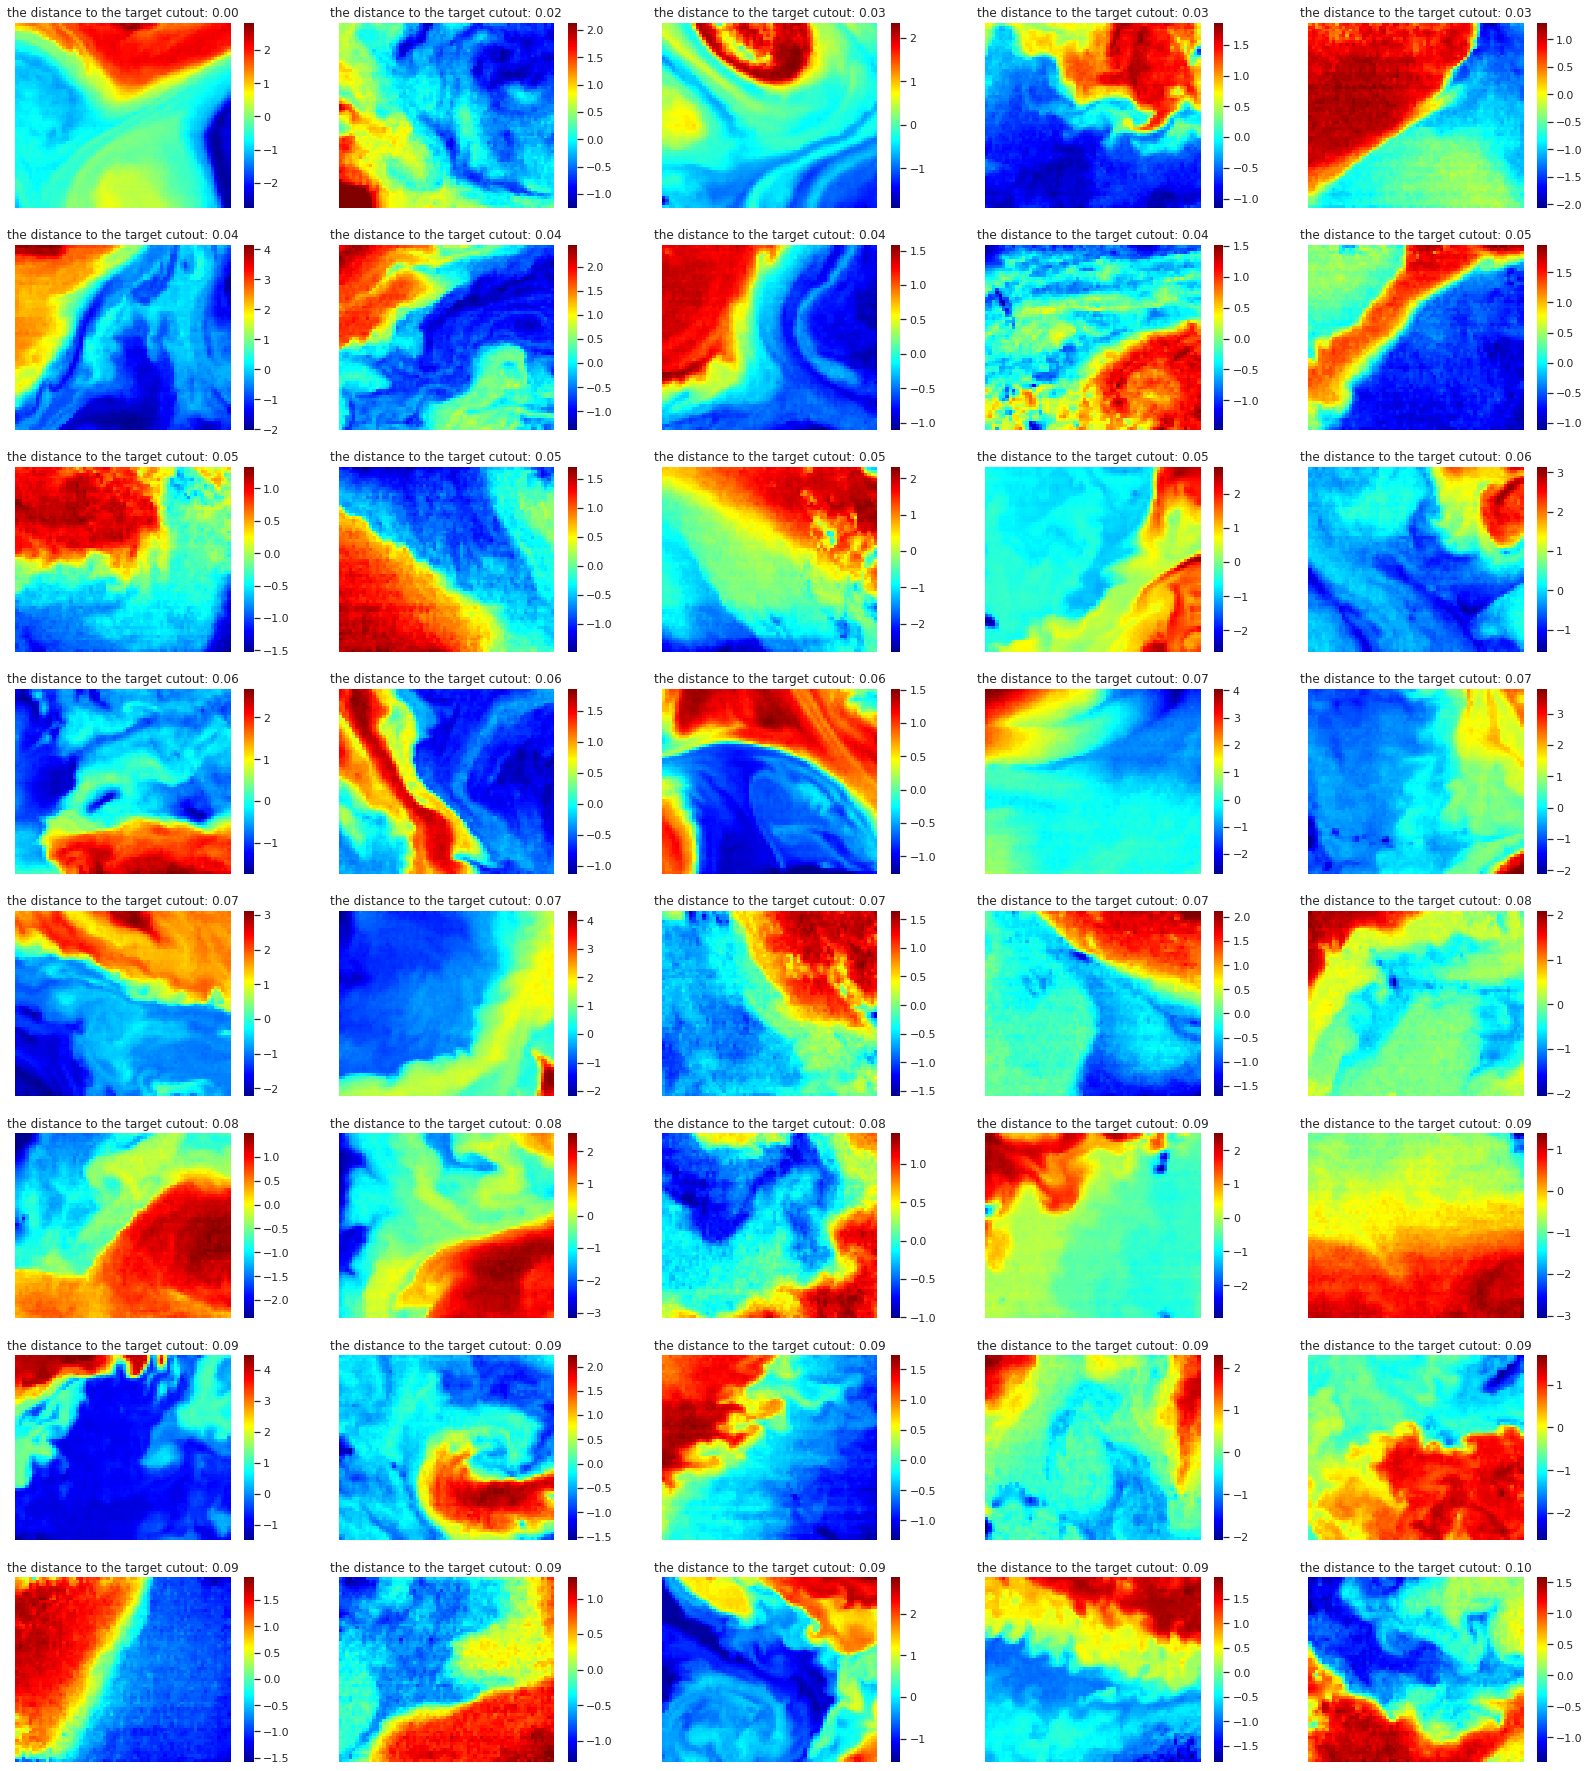

In [232]:
plt.figure(figsize=(28, 32))
for i in range(40):
    plt.subplot(8, 5, i+1)
    sns.heatmap(nearest_imgs[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')